In [ ]:
pip install pyfftw

     |████████████████████████████████| 2.6MB 5.1MB/s 


In [ ]:
import numpy as np
import pyfftw
import h5py
from scipy import signal
import matplotlib.pyplot as plt

In [ ]:
H1 = h5py.File('H-H1_GWOSC_4KHZ_R1-1126259447-32.hdf5',  'r')
L1 = h5py.File('L-L1_GWOSC_4KHZ_R1-1126259447-32.hdf5',  'r')

In [ ]:
strainH1 = H1[u'strain']
strainL1 = L1[u'strain']

dataH1 = np.array(strainH1['Strain'])
dataL1 = np.array(strainL1['Strain'])

In [ ]:
print('strain_H1: len, min, mean, max = ', len(dataH1), dataH1.min(),dataH1.mean(),dataH1.max())
print('strain_L1: len, min, mean, max = ', len(dataL1), dataL1.min(),dataL1.mean(),dataL1.max())

strain_H1: len, min, mean, max =  131072 -7.04466594316914e-19 -3.7594485871462737e-23 7.706262192395323e-19
strain_L1: len, min, mean, max =  131072 -1.8697138664246853e-18 -1.0522364772927026e-18 -4.600351113064713e-20


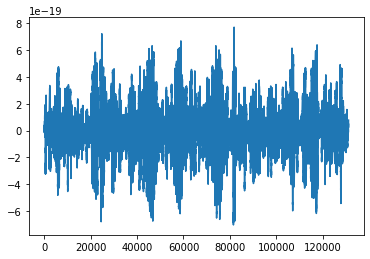

In [ ]:
plt.plot(dataH1)
plt.show()

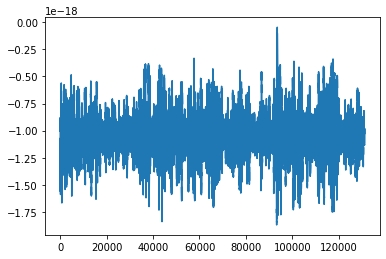

In [ ]:
plt.plot(dataL1)
plt.show()

# Metodo de Blackman-Tukey

In [ ]:
N = 8192
L = len(dataH1)//2
M = 16


Estimo la correlacion de la señal

(131071,)


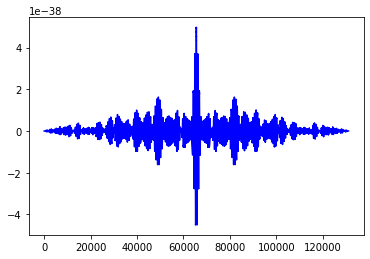

In [ ]:
rx = np.correlate(dataH1[0:L],dataH1[0:L],mode='full') / L
print(rx.shape)
plt.plot(rx,'b')
plt.show()

Aplico la ventana

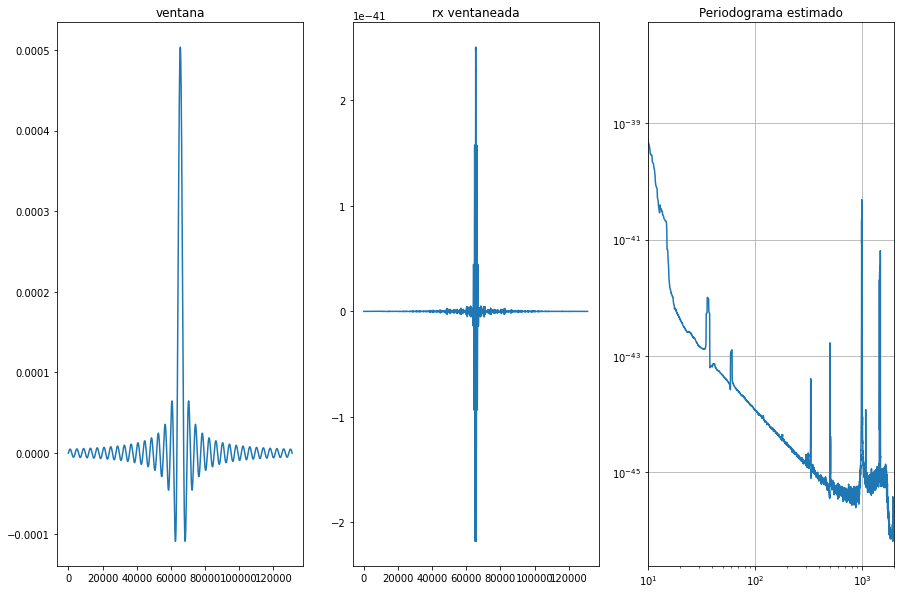

In [ ]:
x = ( (2*M+1)/L )*np.linspace(start=1-L,stop=L,endpoint=False,num=2*L-1,dtype=int)
window = ( (2*M+1)/L )*np.sinc(x)
windowed_rx = rx*window
Rx_ps = np.fft.fft(windowed_rx)
f = np.fft.fftfreq(n=len(windowed_rx),d=1./4096)
spectrum = abs(Rx_ps)
fig = plt.figure(figsize=(15,10))
plt.subplot(131)
plt.plot(window)
plt.title("ventana")
plt.subplot(132)
plt.plot(windowed_rx)
plt.title("rx ventaneada")
plt.subplot(133)
plt.title("Periodograma estimado")
plt.plot(f[0:L],spectrum[0:L])
plt.yscale("log")
plt.xscale("log")
plt.xlim(left=10,right=2000)
plt.grid(True)
plt.show()